<a href="https://colab.research.google.com/github/oscar-defelice/DeepLearning-lectures/blob/master/FinalProject_proposedSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification problem

Here we want to solve a famous text classification problem.
We have the Sentiment 140 Twitter dataset (available [here](https://www.tensorflow.org/datasets/catalog/sentiment140) or in the tensorflow dataset library).

The main objectives are:
1. Show a *brief* preliminary analysis of the data (classes are balanced, useful informations, feature selection, etc)
2. Show some visualisation.
3. Answer questions (later)
4. Train a model with a test accuracy over the $80\%$.
5. *Optional* Deploy the model on a webpage through Tensorflow.js

**Bonus**: make me learn something I did not know 🙂.

#### Important note
Any choice has to be properly explained and justified.

<details>
    <summary><b>HINT</b></summary> 
    
    Make use of open-source implementations of similar problems you can easily find online!
</details>

## The dataset
<details>
    <summary><b>Click to Expand</b></summary> 
    
We will use [twitter_sentiment dataset](https://www.tensorflow.org/datasets/catalog/sentiment140).

### What is Sentiment140?

Sentiment140 allows you to discover the sentiment of a brand, product, or topic on Twitter.

### How does this work?
You can read about our approach in our technical report: [Twitter Sentiment Classification](http://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf) using Distant Supervision. There are also additional features that are not described in this paper.

### Who created this?
Sentiment140 was created by Alec Go, Richa Bhayani, and Lei Huang, who were Computer Science graduate students at Stanford University.

    
**Note**: you can directly download the dataset from [tensorflow datasets](https://www.tensorflow.org/datasets/catalog/sentiment140).
</details>
I suggest you to operate your preprocessing steps and then convert to a tensorflow dataset, which is the robust, and ready-to-parallel computing format you want to use.

In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

--2021-05-26 09:26:30--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M  14.3MB/s    in 7.5s    

2021-05-26 09:26:38 (10.9 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


## Hardware suggestion

I strongly advice to work in colab, or any other environment with a GPU available in order to minimise training time and being able to run multiple model training. 
Recall that experimenting is crucial.

To check whether your instance has a GPU activated you can run the following code
```python
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:    
    raise SystemError('GPU device not found')
```

If you do not have the GPU enabled, just go to:

`Edit -> Notebook Settings -> Hardware accelerator -> Set to GPU`



### Questions to answer

1. Is the dataset balanced?
2. What kind of preprocessing you think is necessary?
3. Can you use some sort of transfer learning? Which one?
4. How many items contains the word "*bush*"?
5. How many items containing the word "*pussy*" are classified as "positive"?
6. How many items are classified as "neutral" and do not contain the words "phone", "computer", "President" and "suck"?

## General assignements

* Write your code following [PEP8 style guide](https://www.python.org/dev/peps/pep-0008/).
* Docstrings has to be written in [Google Style](https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html).
* It is strongly adviced to write your modules to collect functions and import them in the notebook (this will make the following point almost effortless). To import custom modules in colab [look at this example](https://colab.research.google.com/drive/1uvHuizCBqFgvbCwEhK7FvU8JW0AfxgJw#scrollTo=psH0aLrvoh78).
* Once you are sure the notebook runs smoothly, write a python script to be executed from a command line interpreter to train your model:

```bash
python3 -m train --conf config.yml
```

The `config.yml` file has to contain configuration instructions on model architecture (kind of layers, number of layers, number of units, activations, etc.), on training (number of epochs, size of batches, if apply early stopping, optimiser, etc.) and on script metadata (where to get data, where to save output model).

* Finally (optionally), you can serve your model on a webpage thanks to tensorflow.js.

<div style="margin: 0 auto; text-align: center">
    <a href="https://colab.research.google.com/github/oscar-defelice/DeepLearning-lectures/blob/master/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div

## Proposed Solution

First of all, I will explore the dataset to see whether there are null values, etc. We already know a lot about the data thank to the readme of the dataset itself, so not a lot of work is required here. 

I choose pandas over tfds solution also to answer the preliminary questions.

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, Dropout, Activation, MaxPool1D, GlobalMaxPool1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_hub as hub

In [ ]:
path = 'data/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(path, encoding='latin-1', names=['polarity', 'id', 'datetime', 'query', 'user_name', 'text'])

In [ ]:
df

,polarity,id,datetime,query,user_name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Preliminary questions
Here we propose answer to questions above.

#### 1. Is the dataset balanced?

To answer this question we have several possibilities, like counting values, plot an histogram, etc. Since I like fast answers, here I will make use of pandas `df.value_counts()`.

In [ ]:
df['polarity'].value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

Hence, the dataset is perfectly balanced. Here another graphical solution: _i.e._ seaborn `counplot()`

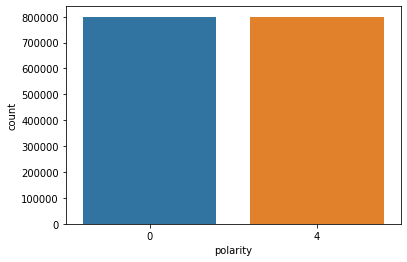

In [ ]:
sns.countplot(x=df.polarity, data=df);

#### 2. What kind of preprocessing you think is necessary?

This question admits many answers, for sure we need to clean and tokenise text. Since we want to get at least sentence structure, we do not want to simply delete `@username` or urls, we can create cleaning functions leveraging regular expressions.

In [ ]:
def clean_regex(text, pattern, special_tkn):
  """clean_regex function to replace some regular expression with special token.
  
  Parameters
  ----------
  text : str
          text to transform containing the regular expression.
  
  pattern: regex.Pattern or str
            regex pattern (if passed as str, the function compile it in 
            regex.Pattern) to select the regular expression.
  
  special_tkn: str
                special token to replace the regular expression.
  
  Returns
  -------
  str : the replaced text.
  """

  try:
    return re.sub(pattern, special_tkn, text)
  except ValueError:
    pattern = re.compile(pattern)
    return re.sub(pattern, special_tkn, text)

With this function, we only need to define our patterns and corresponding substitute strings, it might be useful doing that in a dictionary. This will be part of the constants of our script.

In [ ]:
re_dict = {'user': ('@([A-Za-z0-9_])+', 'xxxusr'),
           'url': ('(http|https)://([A-Za-z0-9_./%])+', 'xxxurl')}

We are now ready to define the proper cleaning function.

In [ ]:
def clean_text(text, regex_patterns = re_dict, lower = True):
  """clean_text function.
  The function we use to clean text in order to feed a later tokeniser.

  Parameters
  ----------
  text : str
          the text to be transformed.

  regex_patterns: dict of str: (str, str)
                    a dictionary containg the name of the subsitution as key 
                    and the tuple (pattern, special_tkn) as values.
  
  lower: bool
          boolean parameter to set whether we want to lower the text before 
          cleaning.
  """
  if lower:
    text = text.lower()
  
  for _, item in regex_patterns.items():
    text = clean_regex(text, item[0], item[1])

  return text

#### 3. Can you use some sort of transfer learning? Which one?

Also here, we have several choices. The simplest one is to use a simple word-embedding like [gloVe](https://nlp.stanford.edu/projects/glove/) or a model available in [tfhub](https://tfhub.dev/).

#### 4. How many items contains the word "bush"?

This and the following questions are just matter of filter over pandas dataframe. I give one answer here and leave the rest as an exercise.

In [ ]:
df.text[df.text.str.contains('bush', case=False)]

939                @BillyBush she admitted to being a fake  
2038       What is common between Chidambaram and George ...
2045       What is common between Chidambaram and George ...
4699       @emmabush Well, I didn't mention the stale Pee...
5099       @airbush  thanks for the guru links, but they ...
                                 ...                        
1573628    @bravesgirl5 naw, just find the nearest bush a...
1581019    @kbushling pho at 4 30 in the morning. Aahh. S...
1583931    @nthlondonhippy Jed Bush being the proposed ob...
1590437                               @meghanbushell Thanks 
1591967             Just woke up going to bush gardens soon 
Name: text, Length: 499, dtype: object

Thus we have $499$ elements in the dataframe containing "bush" before preprocessing.

### The actual code

As said, we want to write a proper-code solution, we already have some preprocessing function that can be stored in a python module called, for instance, `utils.preprocessing.py`

Here we apply such functions and initially build our X, Y arrays.

First, let's clean our text with previously defined functions. At the same time we buil the `y` vector as our polarity divided by $4$.

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)
X = df['clean_text'].values
y = df.polarity.values/4 # defined as an array

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

Hence, let's define and train a tokeniser.

In [ ]:
tokeniser = tf.keras.preprocessing.text.Tokenizer()

In [ ]:
tokeniser.fit_on_texts(X_train)

Let's transform texts to sequences.

In [ ]:
X_train = tokeniser.texts_to_sequences(X_train)
X_test = tokeniser.texts_to_sequences(X_test)

We are ready to pad sequences to `max_len`.

In [ ]:
#@title Tokeniser configuration

max_len = 75#@param {type:"integer"}

vocab_size = len(tokeniser.word_index) + 1 # plus one to take into account the padding token.

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#### The model

Here we can build a model to be trained on sequences.

In [ ]:
#@title Model Parameters
#@markdown Here we give a minimal set of parameters for model configuration.

emb_dim = 64 #@param {type:"integer"}
dropout_rate = 0.3#@param {type: "number"}

learning_rate = 0.001#@param {type: "number"}

loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [ ]:
# build the model
model = Sequential()
model.add(Embedding(vocab_size, output_dim = emb_dim, input_length=max_len))
model.add(Dropout(dropout_rate))
model.add(LSTM(15))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=loss, metrics=[metric], optimizer=opt)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 75, 64)            17805504  
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 15)                4800      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1600      
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

You can see how the Embedding layer contributes for the greatest number of weights.
If you try and train the model like it is, the training time on GPU is around 30 minutes per epoch.

##### Pre-trained Embedding layer



There are several possibilities: 

* GloVe embedding
* You can use [TensorFlow Hub](https://tfhub.dev) available models. This might be a good choice but you lose some control over the text conversion into sequences.

#### Train the model

We are now ready to train our model on data. First we create tensorflow datasets, tehn we call the fit method on our istanciated model.

The training time on GPU is around 30 min per epoch.
You can see how accuracy improves.

In [ ]:
#@title Model Training
#@markdown We can move the slider to set number of epochs 
#@markdown and give a different batch size.

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

number_of_epochs = 3 #@param {type: "slider", min: 1, max: 12}
batch_size = 128 #@param ["2", "8", "16", "32", "64", "128", "256", "512"] {type:"raw", allow-input: true}

# train dataset
ds_train_encoded = train_dataset.shuffle(10000).batch(batch_size)

# test dataset
ds_test_encoded = test_dataset.batch(batch_size)

model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)

Epoch 1/3
10000/10000 [==============================] - 1985s 198ms/step - loss: 0.4153 - accuracy: 0.8096 - val_loss: 0.3871 - val_accuracy: 0.8243
Epoch 2/3
10000/10000 [==============================] - 1974s 197ms/step - loss: 0.3630 - accuracy: 0.8386 - val_loss: 0.3925 - val_accuracy: 0.8265
Epoch 3/3
10000/10000 [==============================] - 1971s 197ms/step - loss: 0.3332 - accuracy: 0.8546 - val_loss: 0.4007 - val_accuracy: 0.8254


As you can see the validation accuracy is over $80\%$ as required.